# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Prepare Data

In [2]:
# Load data
seasons = ['2024-25', '2023-24', '2022-23', '2021-22', '2020-21']
data_frames = []

for season in seasons:
    df = pd.read_csv(f'data/nba_boxscores_{season}.csv')
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

In [3]:
# Sort data based on player and game date
data['gameDate'] = pd.to_datetime(data['gameDate'])

data = data.sort_values('gameDate').reset_index(drop=True)

In [4]:
# Add seconds column
def parse_minutes_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    try:
        # Split by colon
        minutes_part, seconds_part = str(time_str).split(':')
        # Convert minute to float, in case it's like "36.000000"
        minutes = float(minutes_part)
        seconds = int(seconds_part)
        total_seconds = int(minutes * 60 + seconds)
        return total_seconds
    except:
        return None  # if formatting fails
    
data['seconds'] = data['minutes'].apply(parse_minutes_to_seconds)


In [5]:
# Drop rows where player didn't play
data = data[data['seconds'] > 0]

# Feature Engineering

## Player Rolling

In [6]:
def player_rolling(stat, num_games):
    data[f'{stat}_rolling'] = (
        data.groupby('playerSlug')[stat]
            .transform(lambda x: x.shift().rolling(window=num_games).mean())
    )

In [7]:
player_stats = [
    'seconds',
    'fieldGoalsMade',
    'fieldGoalsAttempted',
    'fieldGoalsPercentage',
    'threePointersMade',
    'threePointersAttempted',
    'threePointersPercentage',
    'freeThrowsMade',
    'freeThrowsAttempted',
    'freeThrowsPercentage',
    'reboundsOffensive',
    'reboundsDefensive',
    'reboundsTotal',
    'assists',
    'steals',
    'blocks',
    'turnovers',
    'foulsPersonal',
    'points',
    'plusMinusPoints',
    'estimatedOffensiveRating',
    'offensiveRating',
    'estimatedDefensiveRating',
    'defensiveRating',
    'estimatedNetRating',
    'netRating',
    'assistPercentage',
    'assistToTurnover',
    'assistRatio',
    'offensiveReboundPercentage',
    'defensiveReboundPercentage',
    'reboundPercentage',
    'turnoverRatio',
    'effectiveFieldGoalPercentage',
    'trueShootingPercentage',
    'usagePercentage',
    'estimatedUsagePercentage',
    'estimatedPace',
    'pace',
    'pacePer40',
    'possessions',
    'PIE'
]

In [8]:
for player_stat in player_stats:
    player_rolling(player_stat, 5)

# Opponent Team Rolling

In [9]:
def opp_team_rolling(stat, num_games):
    games = data.drop_duplicates(subset=['gameId', 'teamId'])
    games = games[['gameId', 'teamId', stat]]

    games[f'{stat}_rolling'] = (
        games.groupby('teamId')[stat]
            .transform(lambda x: x.shift().rolling(window=num_games).mean())
    )

    merged_df = pd.merge(
        data,
        games,
        left_on=['gameId', 'opp_teamId'],
        right_on=['gameId', 'teamId'],
        how='left'
    )

    merged_df = merged_df.drop(columns=['teamId_y', f'{stat}_y'])

    stat_base = stat.replace('team_', '', 1)

    merged_df = merged_df.rename(columns={
        'teamId_x': 'teamId',
        f'{stat}_x': f'{stat}',
        f'{stat}_rolling': f'opp_{stat_base}_rolling'
    })

    return merged_df

In [10]:
opp_stats = [
    'team_fieldGoalsMade',
    'team_fieldGoalsAttempted',
    'team_fieldGoalsPercentage',
    'team_threePointersMade',
    'team_threePointersAttempted',
    'team_threePointersPercentage',
    'team_freeThrowsMade',
    'team_freeThrowsAttempted',
    'team_freeThrowsPercentage',
    'team_reboundsOffensive',
    'team_reboundsDefensive',
    'team_reboundsTotal',
    'team_assists',
    'team_steals',
    'team_blocks',
    'team_turnovers',
    'team_foulsPersonal',
    'team_points',
    'team_plusMinusPoints',
    'team_estimatedOffensiveRating',
    'team_offensiveRating',
    'team_estimatedDefensiveRating',
    'team_defensiveRating',
    'team_estimatedNetRating',
    'team_netRating',
    'team_assistPercentage',
    'team_assistToTurnover',
    'team_assistRatio',
    'team_offensiveReboundPercentage',
    'team_defensiveReboundPercentage',
    'team_reboundPercentage',
    'team_estimatedTeamTurnoverPercentage',
    'team_turnoverRatio',
    'team_effectiveFieldGoalPercentage',
    'team_trueShootingPercentage',
    'team_usagePercentage',
    'team_estimatedUsagePercentage',
    'team_estimatedPace',
    'team_pace',
    'team_pacePer40',
    'team_possessions',
    'team_PIE',
]

In [11]:
for opp_stat in opp_stats:
    data = opp_team_rolling(opp_stat, 5)

## Player Performance Against Opponent

In [12]:
def player_vs_opponent_rolling(stat, num_games):
    data[f'{stat}_player_vs_opp_rolling'] = (
        data
        .groupby(['playerSlug', 'opp_teamId'])[stat]
        .rolling(window=num_games)
        .mean()
        .groupby(level=[0, 1]).shift(1)  # shift within each group
        .reset_index(level=[0,1], drop=True)
    )

In [13]:
player_vs_opp_stats = ['points']

In [14]:
for player_vs_opp_stat in player_vs_opp_stats:
    player_vs_opponent_rolling(player_vs_opp_stat, 5)

# Model

Test RMSE: 6.48
Test MAE: 4.99
10-game Average Baseline RMSE: 6.79
10-game Average Baseline MAE: 5.20
RMSE Improvement over baseline: 0.30
MAE Improvement over baseline: 0.21


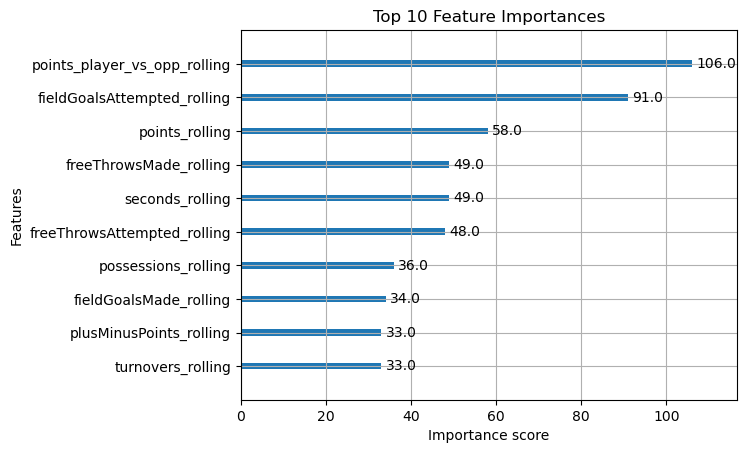

In [15]:
# Select feature to predict
target = "points"

# Select features to train on
opp_stats = [stat.replace("team_", "opp_") for stat in opp_stats]
player_vs_opp_stats = [f"{player_vs_opp_stat}_player_vs_opp" for player_vs_opp_stat in player_vs_opp_stats]
combined = player_stats + opp_stats + player_vs_opp_stats
features = [f"{feature}_rolling" for feature in combined]

# Drop rows with missing data (or impute if you prefer)
data = data.dropna(subset=features + [target])

# Split into features (X) and target (y)
X = data[features]
y = data[target]

# Split train/test by time order to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Train the XGBoost Regressor
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# Evaluate baseline (10-game average)
y_baseline_pred = X_test[f"{target}_rolling"]
baseline_mse = mean_squared_error(y_test, y_baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)
print(f"10-game Average Baseline RMSE: {baseline_rmse:.2f}")
print(f"10-game Average Baseline MAE: {baseline_mae:.2f}")

# Improvement
rmse_improvement = baseline_rmse - rmse
mae_improvement = baseline_mae - mae
print(f"RMSE Improvement over baseline: {rmse_improvement:.2f}")
print(f"MAE Improvement over baseline: {mae_improvement:.2f}")

# Plot Feature Importance
plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()